In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
house_train_data = pd.read_csv('train.csv')
house_test_data = pd.read_csv('test.csv')

In [35]:
house_train_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [36]:
house_train_data.shape

(1460, 81)

In [37]:
house_train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = house_train_data.SalePrice              
X = house_train_data.drop(['SalePrice'], axis=1)

In [38]:
house_train_data.shape

(1460, 81)

In [39]:
house_test_data.shape

(1459, 80)

In [40]:
from sklearn.model_selection import train_test_split

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [41]:
category_cols = [cols for cols in X_train_full.columns if X_train_full[cols].nunique() < 10 and X_train_full[cols].dtype=='object']
number_cols = [cols for cols in X_train_full.columns if X_train_full[cols].dtype in ['int64','float64']]

my_cols = category_cols + number_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = house_test_data[my_cols].copy()

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

number_transformer = SimpleImputer(strategy='mean')

category_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num',number_transformer,number_cols),('category',category_transformer,category_cols)])


In [43]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

my_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',rf_model)])

In [44]:
my_pipeline.fit(X_train, y_train)

val_pred = my_pipeline.predict(X_valid)

print('MAE =',mean_absolute_error(y_valid, val_pred))



MAE = 17721.08506849315


In [45]:
test_pred = my_pipeline.predict(X_test)


In [46]:
from sklearn.model_selection import cross_val_score

score = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring ='neg_mean_absolute_error')

print('Average cross valuation score:',score.mean())

Average cross valuation score: 17708.780691780827


In [47]:
#def val_score_estimator(est):
#    model = RandomForestRegressor(n_estimators=est, random_state=0)
#    my_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',model)])
#    scores = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring ='neg_mean_absolute_error')
#    return scores.mean()
    

#estimators = [100,200,300,400,500]
#val_scores = {}

#for i in estimators:
#    val_scores[i] = val_score_estimator(i)
#print(val_scores)


In [48]:
def final_model(est):
    model = RandomForestRegressor(n_estimators=est, random_state=0)
    my_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',model)])
    my_pipeline.fit(X_train, y_train)
    pred = my_pipeline.predict(X_valid)
    return mean_absolute_error(y_valid, pred)

print('MAE=',final_model(300))

MAE= 17534.869417808215


In [49]:
from xgboost import XGBRegressor
import xgboost as xgb

X_train_xg = pd.get_dummies(X_train)
X_valid_xg = pd.get_dummies(X_valid)
X_test_xg = pd.get_dummies(X_test)
X_train_xg, X_valid_xg = X_train_xg.align(X_valid_xg, join='left', axis=1)
X_train_xg, X_test_xg = X_train_xg.align(X_test_xg, join='left', axis=1)

xgmodel = XGBRegressor(n_estimators=1000, learning_rate = 0.05)
xgmodel.fit(X_train_xg, y_train, early_stopping_rounds=5, eval_set=[(X_valid_xg,y_valid)], verbose=False)
                                                              

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
xg_pred = xgmodel.predict(X_valid_xg)

print('MAE=',mean_absolute_error(y_valid, xg_pred))

MAE= 17106.68447666952


In [51]:
print("Model Accuray: {:.2f}%".format(100*xgmodel.score(X_valid_xg, y_valid)))

Model Accuray: 85.10%


In [52]:
#classifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=42)

In [53]:
#classifier.fit(X_train_xg, y_train)
#class_pred = classifier.predict(X_valid_xg)
#plt.figure(figsize=(100,15))
#xgb.plot_importance(classifier, ax=plt.gca())

In [54]:
# Determine Mutual Information of features
from sklearn.feature_selection import mutual_info_regression

In [72]:
imputer = SimpleImputer(strategy="most_frequent")
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))

imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns



In [73]:
for colname in imputed_X_train.select_dtypes("object"):
    imputed_X_train[colname],_ = imputed_X_train[colname].factorize()

discrete_features = imputed_X_train.dtypes == int

In [91]:
def make_mi_scores(X,y,discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mutual_scores = make_mi_scores(imputed_X_train,y_train,discrete_features)
pd.set_option('display.max_rows', None)
print(mutual_scores)

OverallQual      0.550800
GrLivArea        0.486550
TotalBsmtSF      0.392476
GarageArea       0.391838
GarageCars       0.382907
YearBuilt        0.358085
ExterQual        0.345757
1stFlrSF         0.332596
BsmtQual         0.331483
KitchenQual      0.305827
GarageFinish     0.273859
MSSubClass       0.269505
FullBath         0.256862
GarageYrBlt      0.253267
YearRemodAdd     0.237913
FireplaceQu      0.224133
2ndFlrSF         0.222841
GarageType       0.219898
Foundation       0.206992
LotFrontage      0.198043
TotRmsAbvGrd     0.193208
BsmtFinType1     0.171061
LotArea          0.168235
BsmtFinSF1       0.167604
Fireplaces       0.166441
OpenPorchSF      0.159685
HeatingQC        0.152848
BsmtUnfSF        0.126745
MSZoning         0.111944
OverallCond      0.109020
MasVnrArea       0.101767
MasVnrType       0.101471
WoodDeckSF       0.094382
HouseStyle       0.093690
GarageCond       0.090526
HalfBath         0.084994
LotShape         0.079049
GarageQual       0.077208
BsmtExposure

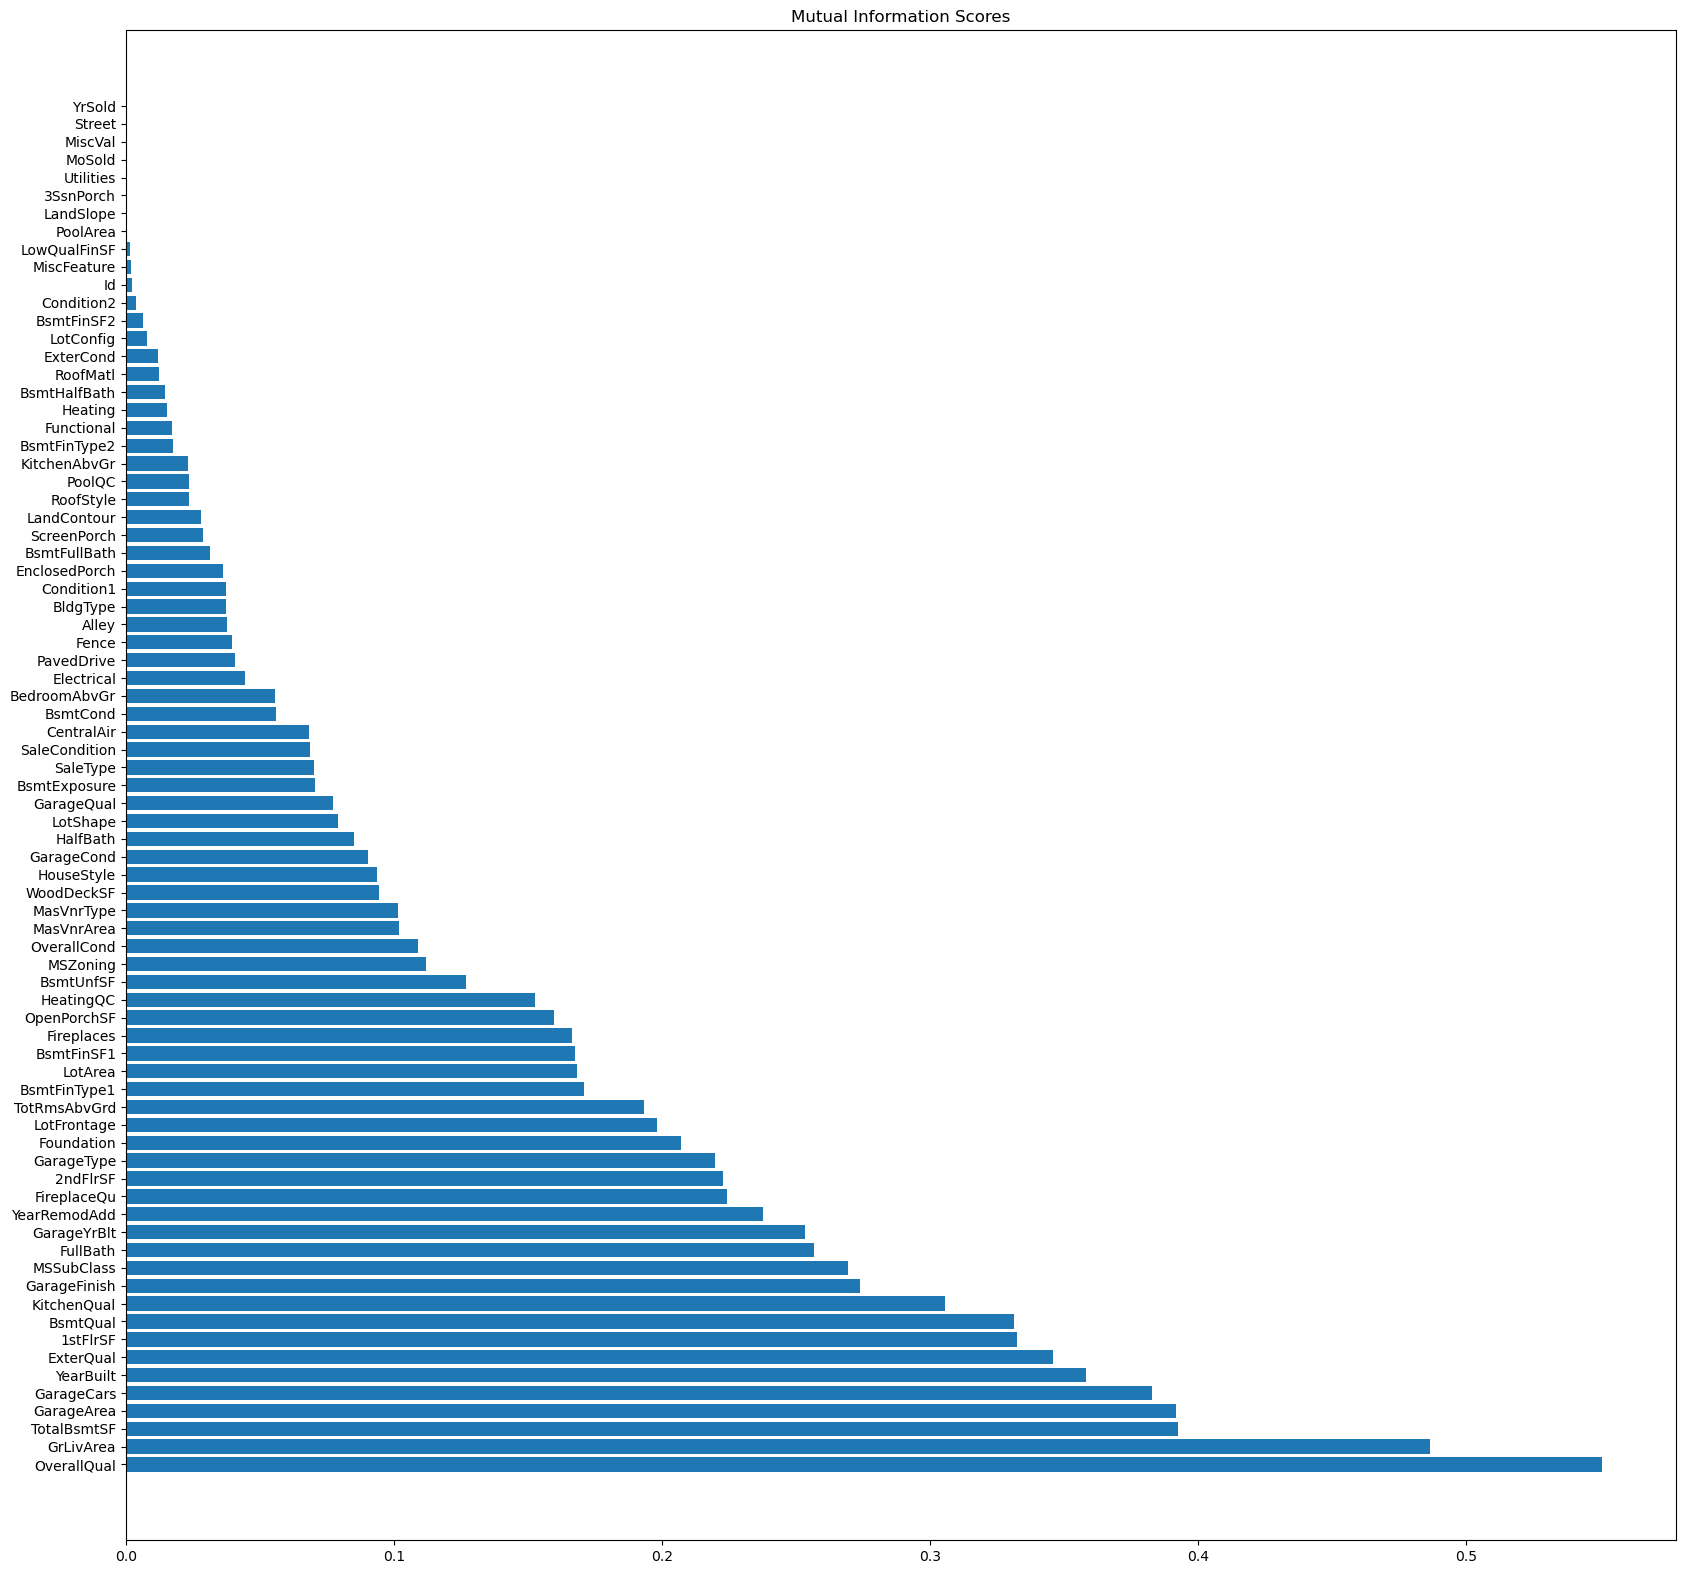

In [92]:
def plot_mi_scores(scores):
    scores.sort_values(ascending=False)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(20, 20))
plot_mi_scores(mutual_scores)